In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from astropy.io import fits

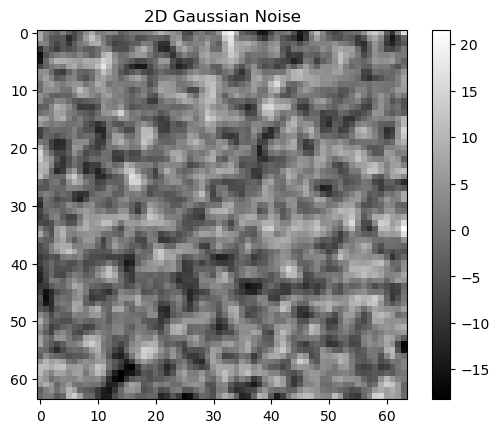

In [89]:
mean = 0     # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution (does not matter since we normalize it later???)


gaussian_noise = np.random.normal(mean, std_dev, size=(64, 64))
#gaussian_noise = gaussian_filter(gaussian_noise, sigma=0.8)

# Plotting the 2D Gaussian noise
plt.imshow(gaussian_noise, cmap='gray')
plt.title('2D Gaussian Noise')
plt.colorbar()
plt.show()

In [90]:
lc = np.load('/Users/dmitryzenko/Projects/Yr4Project/dataset/lc/lc_1.npz')

np.shape(lc['arr_0'])

(64, 64, 86)

lightcones are 64x64x86

In [91]:
noise_cube = np.zeros((64,64,86))

for i in range(86):
    noise_cube[:,:,i] = np.random.normal(mean, std_dev, size=(64, 64))

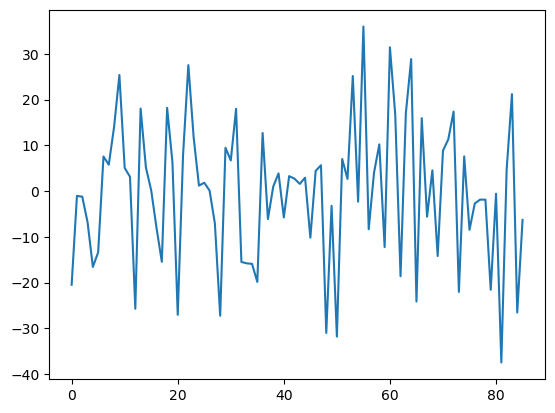

In [92]:
plt.plot(noise_cube[40,40,:])

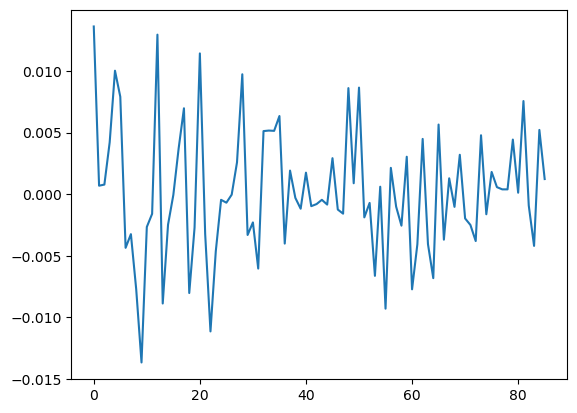

In [93]:
fov=3.0 # field of view in degrees
Dim = 64 # pixels per side
t_int_h = 500 # number of hours to normalise noise to
n_f = 86 # number of frequencies
del_nu = (50/86)*10**6 # frequency interval / Hz
f1 = 108.0 # first frequency map / MHz

#################### Advanced Use #################### 
#SKA

n_tiles = 1 # per station
n_dipoles = 256 # per tile
tel = 'SKA_central_area'
Di = 8 # from baseline design.
const_PSF = 1
PSF_from_headers = 0
if (tel=='SKA_core_area'):
    n_stations = 224 #224
    D =  1000  #3400
elif (tel=='SKA_central_area'):
    n_stations = 296
    D =  3400

c = 2.998e8
eta_a = 1.0 #antenna efficiency
pi = 3.14159
k_b = 1.38e-23
eta_s=0.9 #system efficiency


t_int = t_int_h*3600. # integration time / s


FWHM_arcmin = 4.0
sz=[Dim,Dim]

W = 1.3 #weighting factor (1.3-2) #WE SET THIS AS 1 FOR SUSSEX but also didnt have factor of 2. with equation as they are now, set to 2 to get 67 mK at 150 MHz for 48 stattions. 1.3 89 mK for 24 stations . set to 1.3 to match website.

slice_norm = np.zeros(shape=(sz[0],sz[1]))

noise_norm = np.zeros((64,64,86))


for kk in range(0,n_f):

    freq = f1 + (del_nu*1e-6)*kk
    cube = gaussian_noise
    cube = np.squeeze(cube)
    lamb = c/(freq*1e6)
    # Calculate T_sys
    T_sys = 40.0 + 1.1*60.0*(freq*1e6/c)**(-2.55) # from Table 3 https://astronomers.skatelescope.org/wp-content/uploads/2016/12/SKA-TEL-SKO-DD-001-1_BaselineDesign1.pdf
    # Calculate effective area at each frequency
    eta_rad = (0.056 * freq +82.2)/100.0 # worked out since 85 at 50 MHz and 99 at 300. asssumed linear.
    A_di=lamb**2/(4*pi)*eta_rad*Di #from Table 3 https://astronomers.skatelescope.org/wp-content/uploads/2016/12/SKA-TEL-SKO-DD-001-1_BaselineDesign1.pdf foot note
    if (A_di > 3.2):
        A_di=3.2 # Lower frequencies limited by antenna area
    A=A_di*n_dipoles*n_tiles # Area per station.
 # Calculate SEFD at each frequency.
        #print freq, T_sys-140,A/T_sys
    K=(A)/(2.0*k_b)
    SEFD=T_sys/K # in J m^-2=W m^-2 Hz^-1
    SEFD=SEFD*1.0e26 # in Jy
 # Calculate noise sensitivities in Jy # NOW INCLUDESS FACTOR OF 2.
    noise_Jy=(W/eta_s)*(SEFD/np.sqrt(2*n_stations*(n_stations-1)*del_nu*t_int))
  #  file.write('%e \n'%(noise_Jy))
  #  file2.write('%e \n'%(freq*1e6))

    rms =0.
    for ii in range(0,sz[0]):
        for jj in range(0,sz[1]):
            rms = rms + cube[ii,jj]**2
    rms = np.sqrt(rms/(sz[0]*sz[1]))  # this is in Jy/beam.

    if (const_PSF == 1):
        FWHM = (FWHM_arcmin/60.0)*(pi/180.0)
    else:
        FWHM = 1.22 * lamb / D  # radians
               # print kk,lamb,FWHM

    beamarea = pi * FWHM**2 / (4.0*np.log(2)) # beam solid angle of Gaussian beam

    slice_norm[:,:] = cube[:,:] * (noise_Jy/rms)

    rms_norm =0.
    for ii in range(0,sz[0]):
        for jj in range(0,sz[1]):
            rms_norm = rms_norm + slice_norm[ii,jj]**2

    rms_norm = np.sqrt(rms_norm/(sz[1]*sz[0]))
   # print(noise_Jy, rms_norm)

    slice_norm = slice_norm *1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)) # converting from Jy/beam to K.
   # print(noise_Jy)
   # print(noise_Jy*1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)))
   # print(noise_Jy/beamarea*1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)))
    rms_norm =0.
    for ii in range(0,sz[0]):
        for jj in range(0,sz[1]):
            rms_norm = rms_norm + slice_norm[ii,jj]**2
    rms_norm = np.sqrt(rms_norm/(sz[1]*sz[0]))

    noise_norm[:,:,kk] = noise_cube[:,:,kk]*slice_norm

plt.plot(noise_norm[40,40,:])


---

In [16]:
import numpy as np
import matplotlib.pyplot as plt

mean = 0     # Mean of the distribution
std_dev = 12 # Emmas paper:  https://watermark.silverchair.com/mnras0423-2518.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA2UwggNhBgkqhkiG9w0BBwagggNSMIIDTgIBADCCA0cGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMlksDhYdlDVvlfRrdAgEQgIIDGFJVrQjc8B_IF3hTITowunskfL8zeFMRUyEYiljQtVahqc-KQK7GuT3yZqSI36p2BPOjtyrIL-JHQ5itB3fmlTvK-m4tlYzwvRqzGdNiaVkOq8e3K1F2SLWObiba3ADHqEB0Rz3Q-Wp442MOO_y-fqDYS_q1s8LK2e30i9IgVIzUtIgledPoWUACK_nu3zJvR7Yoe1x0kmHAxYX8C6zcZyMx_uWFw_FhkflkXRhYRKU14KA-jq1AIJuVk2I7SNU4mIpjDM_1noi1X9Wa8yMA_5CLfgMUAQQ9qO4MT_iJpSWyCf36CrsTIatq8pPIYwhrfnIePJs0Ks5a99-bCkTcgMy7WzyOgU5TBlDGOVz2Iw5Ycwg_-NYHNsbrnjI3HZns_OTRLBjMRUXjEVJ-qHTPkHiZuKJ0h79wGKR_YgqEriQWkaFJhGk3bwU4DA-2hOE0yeMrhEayE5ROUQfBVRXyF8BIHcDy-G_qBpPisp2zVEiHWEkAxm5h5UFVu9BFFIyK2fcLHBTcl-7zqbk7dCdm5p5cbYm2yxq3l13HtsMt9E6PJLCJrCJtjC_-L8868rGnLeQGfqYMtDzOlLAdmq3u8pX54zOFuMQbwkJ4fNwwClBfBKPw7ImHKQIUfmhwcxtjwWRr3oeiWinPZ9yq2oIRMTmYrvhoqo8VSd4vepHso-A7k9_2SG09aGn7RPtNLSGcWdBIzpfvf5IUrFaU09kLJaNKvjobbqlQ8V2RB7l2TZJzkvZcKOMpoouDX7PoxvYEVgnwJ9s0aF9TGqIEgBxw0XDUzTMQF__WyG4wjeKM6tSGzgduJ02rR4Q5htgh0UNjrrtRvLWa_DzCfw8YC0mylMXdH0EdF7qmheDv0ObKvk4ulkaExfObA1irEjW_IraSEgM0Jb4Jhwo429xL6G8NZ91DKGAPSvPFCi8Np5_zAgPxwcjzUAuFT-JBpPh5zncgS-qEYvaKjloWmUkkvjKrY2uzG0b5uBT1o6m0PW14C8Y7qQcpmZOP3MRuyj-NeksAzRne_6Kd15PklGePU5cQJ1YomOK79R-ifA

noise_cubes = []
asd= 0
for i in range(10001):

    noise_cube = np.zeros((64,64,86))
    for i in range(86):
        noise_cube[:,:,i] = np.random.normal(mean, std_dev, size=(64, 64))

    fov=3.0 # field of view in degrees
    Dim = 64 # pixels per side
    t_int_h = 1000 # number of hours to normalise noise to
    n_f = 86 # number of frequencies
    del_nu = (50/86)*10**6 # frequency interval / Hz
    f1 = 108.0 # first frequency map / MHz

    #################### Advanced Use #################### 
    #SKA

    n_tiles = 1 # per station
    n_dipoles = 256 # per tile
    tel = 'SKA_central_area'
    Di = 8 # from baseline design.
    const_PSF = 1
    PSF_from_headers = 0
    if (tel=='SKA_core_area'):
        n_stations = 224 #224
        D =  1000  #3400
    elif (tel=='SKA_central_area'):
        n_stations = 296
        D =  3400

    c = 2.998e8
    eta_a = 1.0 #antenna efficiency
    pi = 3.14159
    k_b = 1.38e-23
    eta_s=0.9 #system efficiency


    t_int = t_int_h*3600. # integration time / s


    FWHM_arcmin = 4.0
    sz=[Dim,Dim]

    W = 1.3 #weighting factor (1.3-2) #WE SET THIS AS 1 FOR SUSSEX but also didnt have factor of 2. with equation as they are now, set to 2 to get 67 mK at 150 MHz for 48 stattions. 1.3 89 mK for 24 stations . set to 1.3 to match website.

    slice_norm = np.zeros(shape=(sz[0],sz[1]))

    noise_norm = np.zeros((64,64,86))

    for kk in range(0,n_f):

        freq = f1 + (del_nu*1e-6)*kk

        lamb = c/(freq*1e6)
        # Calculate T_sys
        T_sys = 40.0 + 1.1*60.0*(freq*1e6/c)**(-2.55) # from Table 3 https://astronomers.skatelescope.org/wp-content/uploads/2016/12/SKA-TEL-SKO-DD-001-1_BaselineDesign1.pdf
        # Calculate effective area at each frequency
        eta_rad = (0.056 * freq +82.2)/100.0 # worked out since 85 at 50 MHz and 99 at 300. asssumed linear.
        A_di=lamb**2/(4*pi)*eta_rad*Di #from Table 3 https://astronomers.skatelescope.org/wp-content/uploads/2016/12/SKA-TEL-SKO-DD-001-1_BaselineDesign1.pdf foot note
        if (A_di > 3.2):
            A_di=3.2 # Lower frequencies limited by antenna area
        A=A_di*n_dipoles*n_tiles # Area per station.
    # Calculate SEFD at each frequency.
            #print freq, T_sys-140,A/T_sys
        K=(A)/(2.0*k_b)
        SEFD=T_sys/K # in J m^-2=W m^-2 Hz^-1
        SEFD=SEFD*1.0e26 # in Jy
    # Calculate noise sensitivities in Jy # NOW INCLUDESS FACTOR OF 2.
        noise_Jy=(W/eta_s)*(SEFD/np.sqrt(2*n_stations*(n_stations-1)*del_nu*t_int))


        rms =0.
        for ii in range(0,sz[0]):
            for jj in range(0,sz[1]):
                rms = rms + cube[ii,jj]**2
        rms = np.sqrt(rms/(sz[0]*sz[1]))  # this is in Jy/beam.

        if (const_PSF == 1):
            FWHM = (FWHM_arcmin/60.0)*(pi/180.0)
        else:
            FWHM = 1.22 * lamb / D  # radians
                # print kk,lamb,FWHM

        beamarea = pi * FWHM**2 / (4.0*np.log(2)) # beam solid angle of Gaussian beam

        slice_norm[:,:] = cube[:,:] * (noise_Jy/rms)

        rms_norm =0.
        for ii in range(0,sz[0]):
            for jj in range(0,sz[1]):
                rms_norm = rms_norm + slice_norm[ii,jj]**2

        rms_norm = np.sqrt(rms_norm/(sz[1]*sz[0]))

        slice_norm = slice_norm *1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)) # converting from Jy/beam to K.

        rms_norm =0.
        for ii in range(0,sz[0]):
            for jj in range(0,sz[1]):
                rms_norm = rms_norm + slice_norm[ii,jj]**2
        rms_norm = np.sqrt(rms_norm/(sz[1]*sz[0]))

        noise_norm[:,:,kk] = noise_cube[:,:,kk]*slice_norm

    noise_cubes.append(noise_norm)
    asd+=1
    print(asd)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


: 

: 

In [1]:
noise_cubes

NameError: name 'noise_cubes' is not defined